In [1]:
! pip install torchmetrics torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
import os
import sys
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
from tqdm.notebook import tqdm
from torcheval.metrics.functional import multiclass_accuracy, multiclass_auprc
from torchmetrics import JaccardIndex
jaccardidx = JaccardIndex(task="BINARY")
jaccardidx.__name__ = 'JaccardIndex'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
work_dir = "/content/drive/MyDrive/Deep_learning_course/Lung_segmentation/classification_segmentation/"
sys.path.append(work_dir)

In [5]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
from unet_mobilenet import NetCovid
from custom_load import LungDatasetLoader

### Move data to localpath

In [7]:
path_to_zip_folder = '/content/drive/MyDrive/Deep_learning_course/Lung_segmentation/data/m3ex02-data.zip'
current_folder_path = '/content/localpath/'
!unzip -q $path_to_zip_folder -d $current_folder_path

### Define parameters

In [36]:
# data parameters
data_path: str = '/content/localpath/m3ex02-data/'
path_test: str = os.path.join(data_path, 'Test/')
path_train: str = os.path.join(data_path, 'Train/')
path_eval: str = os.path.join(data_path, 'Val/')
# training parameters
batch_size: int = 120
workers: int = 8
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model parameters
path_load: str = '/content/drive/MyDrive/Deep_learning_course/Lung_segmentation/classification_segmentation/models/'
name_load: str = 'model_test_3.pkl'
in_channels: int = 1
out_channels: int = 1
num_classes: int = 3

### Load data

In [37]:
data_test = LungDatasetLoader(
    path_test,
    batch_size=batch_size,
    workers=workers,
    pin_memory_device=device
)

### Load pre-trained models

In [38]:
jaccardidx.to(device)

BinaryJaccardIndex()

In [39]:
model = NetCovid(
    in_channels=in_channels,
    num_classes=num_classes,
    seg_channels=out_channels,
)
state_dict = torch.load(os.path.join(path_load, name_load))
model.load_state_dict(state_dict["model"])
model = model.to(device)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [40]:
def test_model(model_, data_test):
  tot = len(data_test)
  model_.to(device)
  model_.eval()
  with torch.no_grad():
    test_iou = []
    test_auprc = []
    test_accuracy = []

    for i, (batch) in tqdm(enumerate(data_test), total=tot):
      batch_image = batch["image"].to(device)
      batch_mask = batch["mask"].unsqueeze(1).to(device)
      batch_class = batch["class"].to(device)

      y_pred_mask, y_pred_class = model_(batch_image)

      mask_iou = jaccardidx(y_pred_mask, batch_mask)
      accuracy = multiclass_accuracy(y_pred_class, batch_class)
      auprc = multiclass_auprc(y_pred_class, batch_class)

      test_iou.append(mask_iou.detach().cpu().numpy())
      test_accuracy.append(accuracy.detach().cpu().numpy())
      test_auprc.append(auprc.detach().cpu().numpy())

  test_metrics = {
      "iou": np.mean(test_iou),
      "accuracy": np.mean(test_accuracy),
      "auprc": np.mean(test_auprc)
  }

  return test_metrics

In [41]:
def plot_image_mask(model, data, index):
  X = data.dataset[index]
  image = X["image"]
  image_ = image.unsqueeze(0)
  image_ = image_.to(device)
  model = model.to(device)
  model.eval()
  with torch.no_grad():
    y_pred, _ = model(image_)
  mask = y_pred[0] > 0.5
  mask = mask.cpu().numpy()
  plt.imshow(image[0])
  plt.imshow(mask[0], alpha=0.5)

In [42]:
output = test_model(model, data_test)

  0%|          | 0/57 [00:00<?, ?it/s]

In [35]:
output

{'iou': 0.85640204, 'accuracy': 0.49416062, 'auprc': 0.33637777}

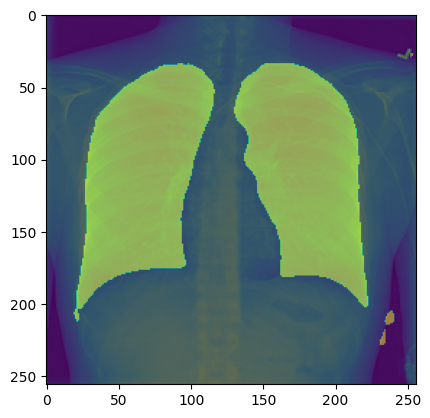

In [44]:
plot_image_mask(model, data_test, 150)